In [511]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import random
import scipy.stats as stats
warnings.filterwarnings('ignore')

%matplotlib inline

In [422]:
#load data and take a look at first five rows

df = pd.read_csv('Life Expectancy Data.csv')

#some of the column titles are double spaced or have spaces before/after

df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace('  ', ' ')
df.head()


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [423]:
#check data types. All numerical columns are either float or int. This tells us that 
#there are no alpabetical characters in them.
df.dtypes

Country                             object
Year                                 int64
Status                              object
Life expectancy                    float64
Adult Mortality                    float64
infant deaths                        int64
Alcohol                            float64
percentage expenditure             float64
Hepatitis B                        float64
Measles                              int64
BMI                                float64
under-five deaths                    int64
Polio                              float64
Total expenditure                  float64
Diphtheria                         float64
HIV/AIDS                           float64
GDP                                float64
Population                         float64
thinness 1-19 years                float64
thinness 5-9 years                 float64
Income composition of resources    float64
Schooling                          float64
dtype: object

In [424]:
#check for how many unique values there are. Any binary columns should only have 2 unique answers (status)
df.nunique()

Country                             193
Year                                 16
Status                                2
Life expectancy                     362
Adult Mortality                     425
infant deaths                       209
Alcohol                            1076
percentage expenditure             2328
Hepatitis B                          87
Measles                             958
BMI                                 608
under-five deaths                   252
Polio                                73
Total expenditure                   818
Diphtheria                           81
HIV/AIDS                            200
GDP                                2490
Population                         2278
thinness 1-19 years                 200
thinness 5-9 years                  207
Income composition of resources     625
Schooling                           173
dtype: int64

In [425]:
#do a quick glance of unique values 
for column_name in df.columns:
    print("Unique values in column {} are: {}".format(column_name, df[column_name].unique()))
    

Unique values in column Country are: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso'
 'Burundi' "Côte d'Ivoire" 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia'
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada' 'Guatemala' 'Guinea'
 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'India'
 'In

In [426]:
#get a count for how many null values are in each column
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness 1-19 years                 34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

In [427]:
#change any value in numerical columns that cant be converted into null value
cnt=0
for column_name in df.columns[3:]:
    for row in df[column_name]:
        try:
            float(row)
        except ValueError:
            df.loc[cnt, column_name]=np.nan
            pass
    cnt+=1


In [428]:
#gives the actual data point for anything that cant be converted into a float
for column_name in df.columns[3:]:
    print("These are the problematic values for the variable: {}".format(column_name))
    for value in df[column_name]:
        try:
            float(value)
        except:
            print(value)

These are the problematic values for the variable: Life expectancy
These are the problematic values for the variable: Adult Mortality
These are the problematic values for the variable: infant deaths
These are the problematic values for the variable: Alcohol
These are the problematic values for the variable: percentage expenditure
These are the problematic values for the variable: Hepatitis B
These are the problematic values for the variable: Measles
These are the problematic values for the variable: BMI
These are the problematic values for the variable: under-five deaths
These are the problematic values for the variable: Polio
These are the problematic values for the variable: Total expenditure
These are the problematic values for the variable: Diphtheria
These are the problematic values for the variable: HIV/AIDS
These are the problematic values for the variable: GDP
These are the problematic values for the variable: Population
These are the problematic values for the variable: thinne

I tried many different ways to fill the null values. I initially tried to do a regression imputation but i could not get it to do it by country. I decided to initially interpolate the data by country as opposed to using mean/mode/median since the dataset is a time series and i can group it by country. Because there were still a lot of null values in the data set even after interpolation, I decided to fill the remaining data with the median values. It is better to at least have some data than to have to remove an entire rows worth of data. Using interpolation will reduce the variance in the dataset and using median will reduce the variance as well as skew the descriptive statistics. I chose median over mean because there are so many outliers in this data set.

In [429]:
#interpolate data where possible because the data is a time series. Doing so may reduce variance in the data 
#but it is better than having null values

for column_name in df.columns[3:]:
    df[column_name] = df.groupby('Country')[column_name].transform(lambda x: x.fillna(x.interpolate()))

In [430]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            193
percentage expenditure               0
Hepatitis B                        144
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                                0
Total expenditure                  211
Diphtheria                           0
HIV/AIDS                             0
GDP                                422
Population                         652
thinness 1-19 years                 34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

In [431]:
#fill remaining null values with the median of that column
for column_name in df.columns[3:]:
    df[column_name] = df[column_name].transform(lambda x: x.fillna(x.median()))

In [432]:
#give descriptive stats of the dataset
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.234717,164.725664,30.303948,4.546186,738.251295,76.462560,2419.592240,38.381178,42.035739,82.307692,5.907968,82.075221,1.742103,6596.927849,1.023085e+07,4.821886,4.852144,0.630362,12.009837
std,4.613841,9.509115,124.086215,117.926501,3.922134,1987.914858,28.052618,11467.272489,19.935375,160.445548,23.636677,2.409850,23.917022,5.077785,13302.460100,5.402242e+07,4.397621,4.485854,0.205140,3.265139
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.200000,74.000000,0.000000,1.092500,4.685343,68.000000,0.000000,19.400000,0.000000,77.000000,4.340000,78.000000,0.100000,563.517201,4.189172e+05,1.600000,1.600000,0.504250,10.300000
50%,2008.000000,72.100000,144.000000,3.000000,3.750000,64.912906,89.000000,17.000000,43.500000,4.000000,93.000000,5.720000,93.000000,0.100000,1727.590500,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.600000,227.000000,22.000000,7.390000,441.534144,96.000000,360.250000,56.100000,28.000000,97.000000,7.330000,97.000000,0.800000,4779.405190,4.584371e+06,7.100000,7.200000,0.772000,14.100000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


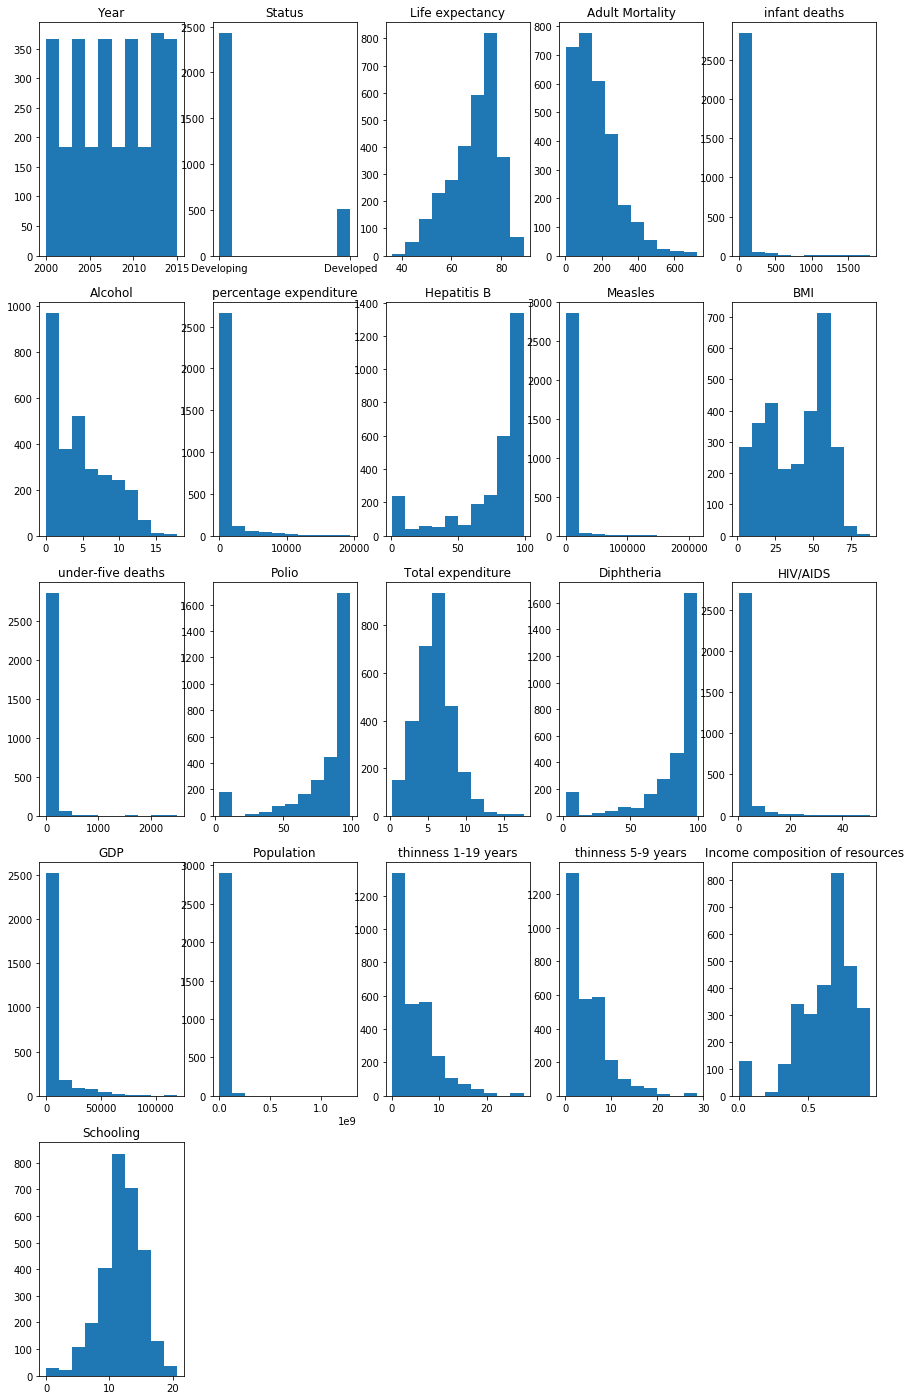

In [433]:
#histogram of values in each column
i = 1
plt.figure(figsize=(15,10))
for column_name in df.columns[1:]:
    plt.subplot(5,5,i)
    plt.hist(df[column_name])
    plt.title(df.columns[i])
    i = i+1
    
plt.subplots_adjust(bottom=-1)
plt.tight_layout()
plt.show()

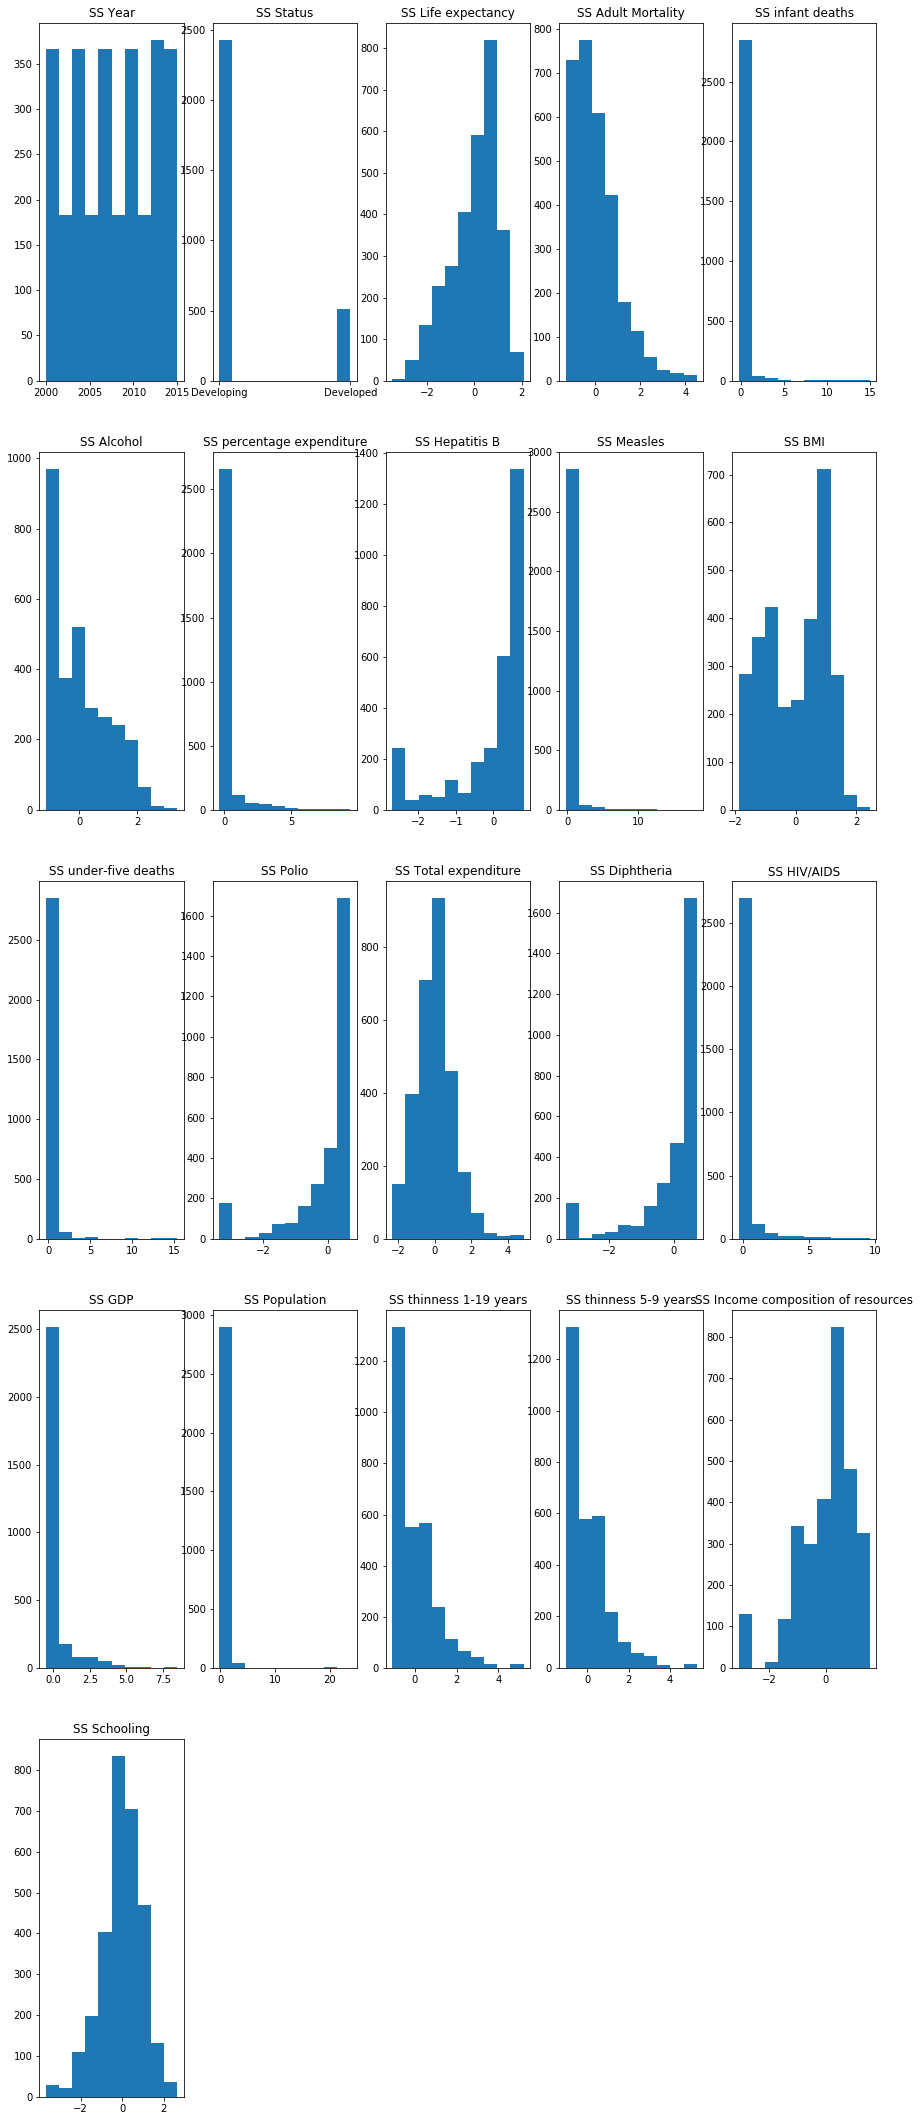

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,-0.445408,0.792119,0.268824,-1.156758,-0.335570,-0.408679,-0.110384,...,-3.228909,0.934670,-0.714057,-0.323445,-0.452074,0.435183,2.815209,2.775386,-0.737973,-0.585017
1,Afghanistan,2014,Developing,-0.981827,0.856601,0.285786,-1.156758,-0.334441,-0.515639,-0.168124,...,-1.028564,0.942971,-0.839512,-0.323445,-0.449936,-0.183349,2.883439,2.819978,-0.752600,-0.615649
2,Afghanistan,2013,Developing,-0.981827,0.832421,0.302749,-1.156758,-0.334594,-0.444332,-0.173531,...,-0.859306,0.922219,-0.755876,-0.323445,-0.448503,0.398066,2.928926,2.864570,-0.781853,-0.646281
3,Afghanistan,2012,Developing,-1.023899,0.864662,0.328193,-1.156758,-0.332096,-0.337372,0.032045,...,-0.647735,1.084083,-0.630421,-0.323445,-0.445630,-0.120968,2.974413,2.931458,-0.815982,-0.676912
4,Afghanistan,2011,Developing,-1.055453,0.888843,0.345155,-1.156758,-0.367862,-0.301719,0.051757,...,-0.605420,0.814310,-0.588602,-0.323445,-0.491225,-0.134268,3.042643,2.976051,-0.859862,-0.768808
5,Afghanistan,2010,Developing,-1.097525,0.921084,0.370599,-1.156758,-0.331344,-0.373025,-0.037556,...,-0.690049,1.366306,-0.672239,-0.323445,-0.454399,-0.136035,3.088130,3.020643,-0.889116,-0.860703
6,Afghanistan,2009,Developing,-1.118561,0.937204,0.396043,-1.156758,-0.342874,-0.479986,0.038499,...,-0.816992,1.457614,-0.797694,-0.323445,-0.462477,-0.184150,3.133617,3.087531,-0.957374,-0.952598
7,Afghanistan,2008,Developing,-1.171151,0.985566,0.421487,-1.151658,-0.358415,-0.444332,-0.071572,...,-0.774678,1.005226,-0.755876,-0.323445,-0.467930,-0.138881,3.179104,3.132123,-0.962249,-1.013862
8,Afghanistan,2007,Developing,-1.234259,1.050048,0.438450,-1.154208,-0.365944,-0.479986,-0.111518,...,-0.816992,0.341171,-0.797694,-0.323445,-0.468196,0.303369,3.224591,3.176715,-1.050009,-1.105757
9,Afghanistan,2006,Developing,-1.255295,1.050048,0.455412,-1.151658,-0.362793,-0.444332,-0.037469,...,-1.028564,0.631695,-1.006786,-0.323445,-0.475509,-0.141475,3.270078,3.221308,-1.098765,-1.197653


In [434]:
#standard scaler of features. If we decide that we need the features to be normally distributed
scaler = StandardScaler()
impute_data_scaler = df[df.columns[3:]]
impute_data_scaler = pd.DataFrame(scaler.fit_transform(impute_data_scaler), columns = df.columns[3:])
impute_data_scaler = pd.concat([df[df.columns[:3]], impute_data_scaler], axis=1)
impute_data_scaler.head(15)

i = 1
plt.figure(figsize=(15,10))
for column_name in impute_data_scaler.columns[1:]:
    plt.subplot(5,5,i)
    plt.hist(impute_data_scaler[column_name])
    plt.title('SS ' + impute_data_scaler.columns[i])
    i = i+1
    
plt.subplots_adjust(bottom=-2)
plt.tight_layout()
plt.show()

impute_data_scaler.head(15)

<Figure size 1080x720 with 0 Axes>

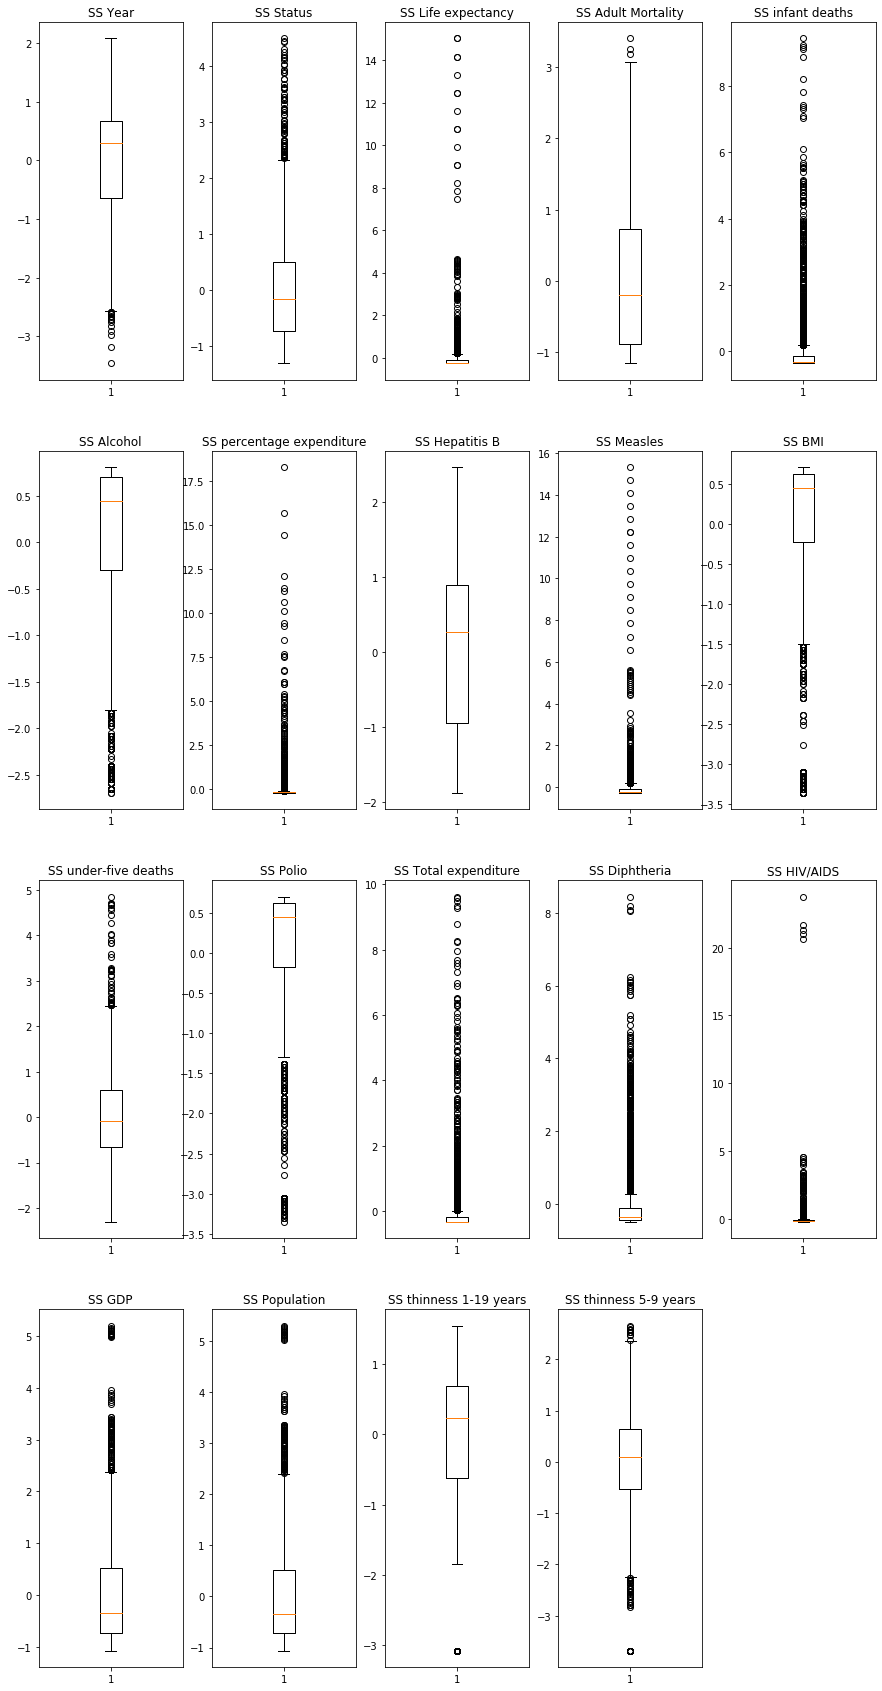

In [436]:
#boxplot of standard scaler (SS) values
i = 1
plt.figure(figsize=(15,10))

i = 1
plt.figure(figsize=(15,10))
for column_name in impute_data_scaler.columns[3:]:
    plt.subplot(5,5,i)
    plt.boxplot(impute_data_scaler[column_name])
    plt.title('SS ' + impute_data_scaler.columns[i])
    i = i+1
    
plt.subplots_adjust(bottom=-2)
plt.tight_layout()
plt.show()

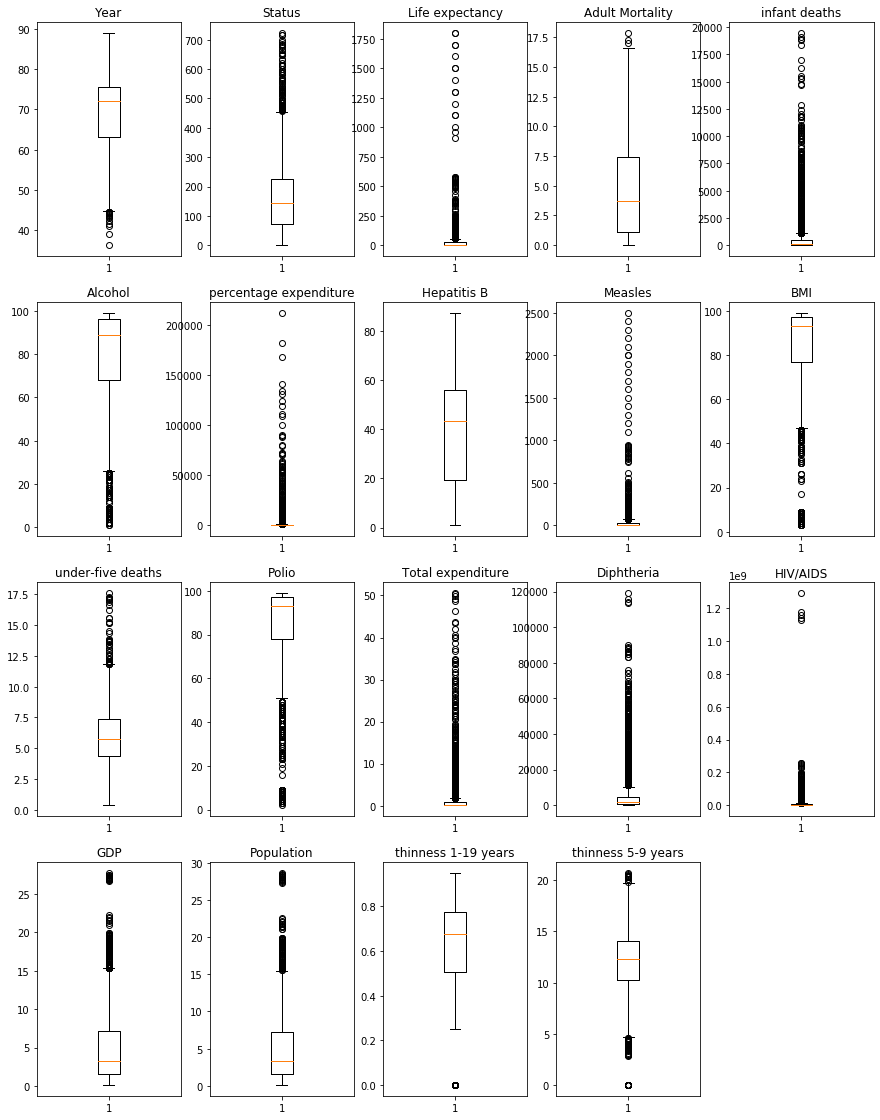

In [437]:
#boxplot of values in each column
i = 1
plt.figure(figsize=(15,10))
for column_name in df.columns[3:]:
    plt.subplot(5,5,i)
    plt.boxplot(df[column_name])
    plt.title(df.columns[i])
    i = i+1
    
plt.subplots_adjust(bottom=-1)
plt.tight_layout()
plt.show()


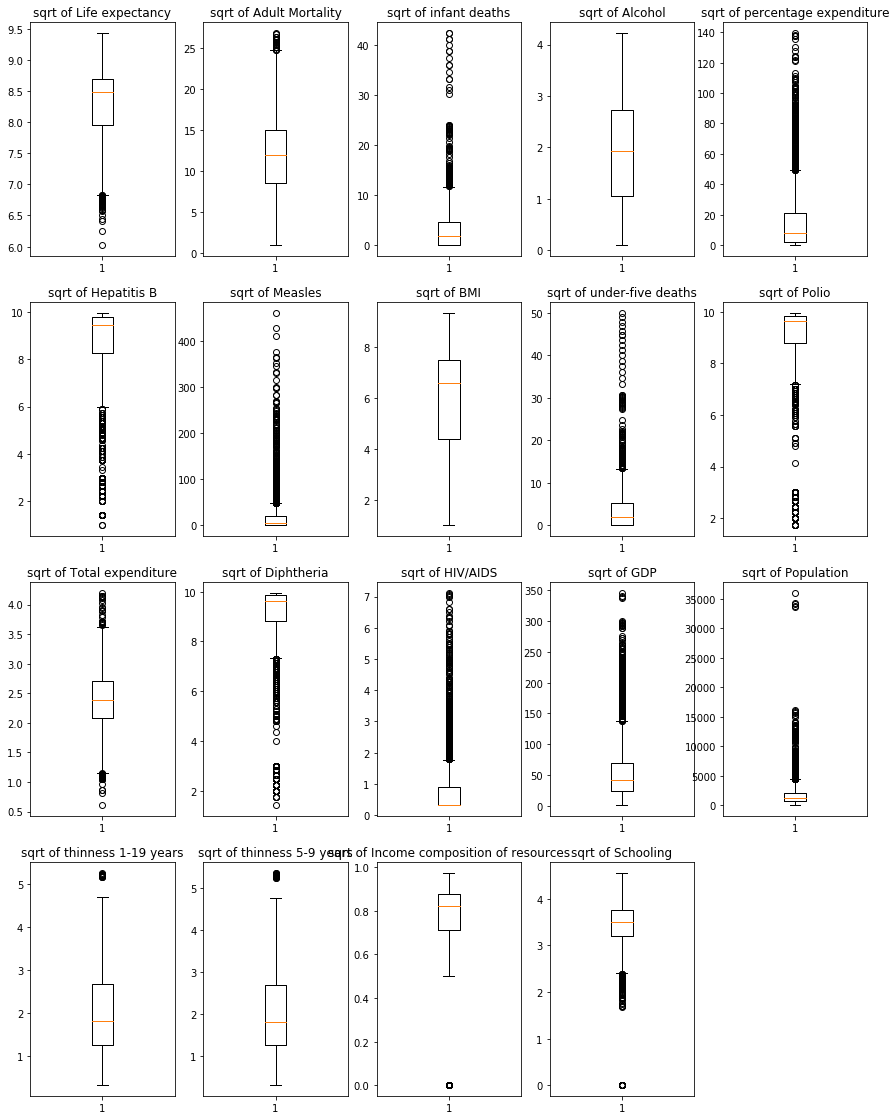

In [438]:
#boxplot of square root values in each column
i = 1
plt.figure(figsize=(15,10))
for column_name in df.columns[3:]:
    plt.subplot(5,5,i)
    plt.boxplot(np.sqrt(df[column_name]))
    plt.title('sqrt of ' + df.columns[i+2])
    i = i+1
    
plt.subplots_adjust(bottom=-1)
plt.tight_layout()
plt.show()

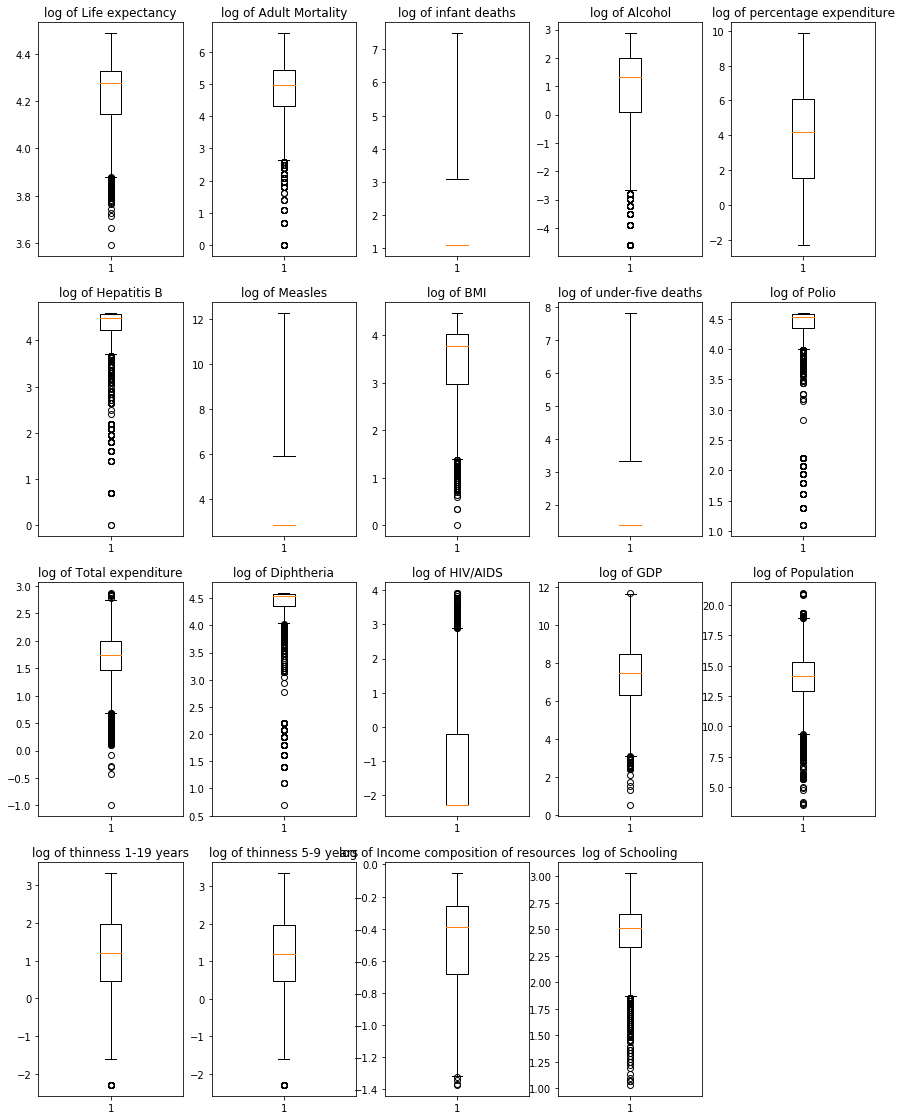

In [439]:
#boxplot of log values in each column
i = 1
plt.figure(figsize=(15,10))
for column_name in df.columns[3:]:
    plt.subplot(5,5,i)
    plt.boxplot(np.log(df[column_name]))
    plt.title('log of ' + df.columns[i+2])
    i = i+1
    
plt.subplots_adjust(bottom=-1)
plt.tight_layout()
plt.show()

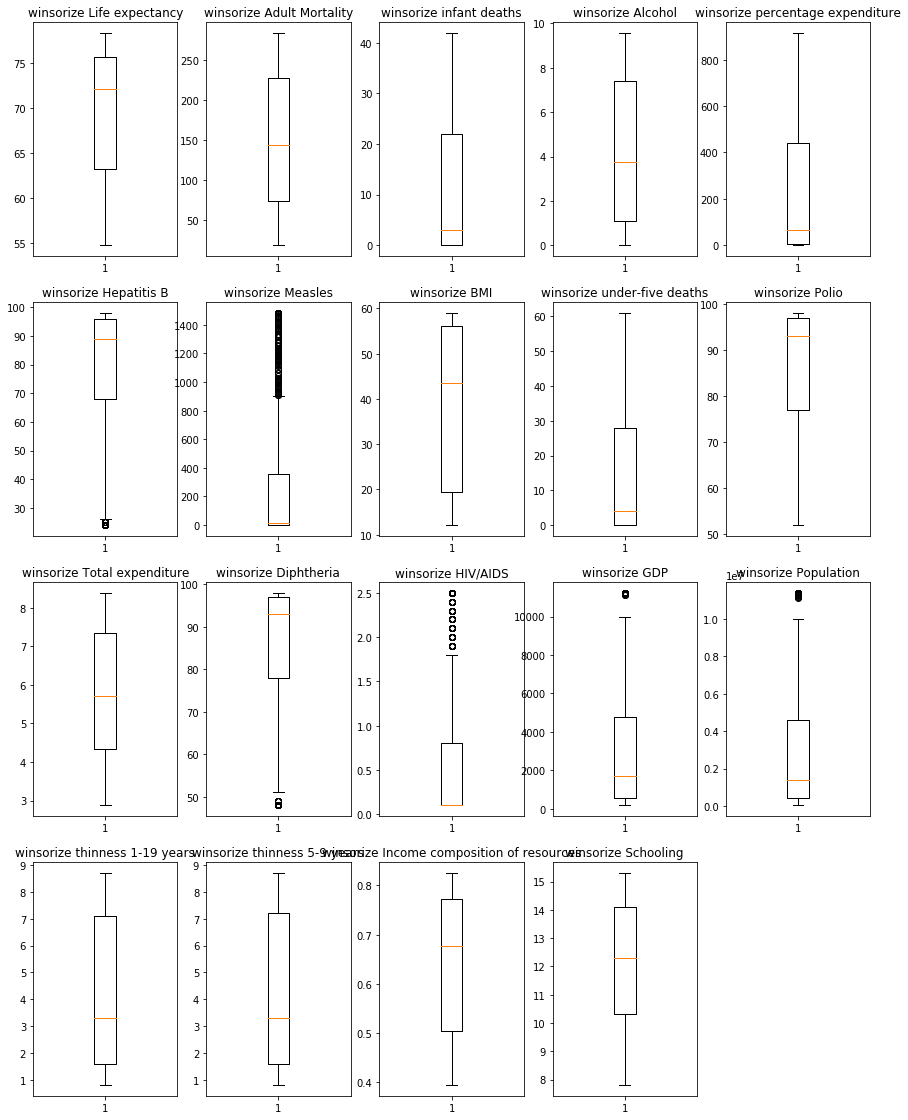

In [440]:
#boxplot of winsorized values

i = 1
plt.figure(figsize=(15,10))
for column_name in df.columns[3:]:
    plt.subplot(5,5,i)
    plt.boxplot(winsorize(df[column_name], limits = [0.1, 0.15]))
    plt.title('winsorize ' + df.columns[i+2])
    i = i+1
    
plt.subplots_adjust(bottom=-1)
plt.tight_layout()
plt.show()


In [441]:
# determine if winsorizing columns reduced outliers
for column_name in df.columns[3:]:
    print('\noutliers for {}\n'.format(column_name))
    q75, q25 = np.percentile(df[column_name], [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(1,5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print("The score threshold is: {}".format(threshold))
        print("Number of outliers is: {}".format(
            len((np.where((df[column_name] > max_val) 
                      | (df[column_name] < min_val))[0]))
        ))
            
    
        winsorized_val = winsorize(df[column_name], limits = [0.1, 0.15])
    print('\noutliers for winsorize {}\n'.format(column_name))
    q75, q25 = np.percentile(winsorized_val, [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(1,5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print("The score threshold is: {}".format(threshold))
        print("Number of outliers is: {}".format(
            len((np.where((winsorized_val > max_val) 
                      | (winsorized_val < min_val))[0]))
        )) 


outliers for Life expectancy

The score threshold is: 1.0
Number of outliers is: 148
The score threshold is: 1.5
Number of outliers is: 17
The score threshold is: 2.0
Number of outliers is: 1
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0

outliers for winsorize Life expectancy

The score threshold is: 1.0
Number of outliers is: 0
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0

outliers for Adult Mortality

The score threshold is: 1.0
Number of outliers

The score threshold is: 3.0
Number of outliers is: 178
The score threshold is: 3.5
Number of outliers is: 37
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0

outliers for winsorize Polio

The score threshold is: 1.0
Number of outliers is: 340
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0

outliers for Total expenditure

The score threshold is: 1.0
Number of outliers is: 147
The score threshold is: 1.5
Number of outliers is: 47
The score threshold is: 2.0
Number of outliers is: 26
The score threshold is: 2.5
Number of outliers is: 14
The score threshold is: 3.0
Number of outliers is: 8
The score threshold is: 3

The score threshold is: 4.5
Number of outliers is: 0

outliers for winsorize Schooling

The score threshold is: 1.0
Number of outliers is: 0
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [442]:
#winsorize dataset and then add it to the end of the original dataset
df1 = df.iloc[:, 3:]
for column_name in df1.columns:
    df1[column_name] = winsorize(df1[column_name], limits = [0.1, 0.15])

df1.columns = [str(col) + '_winsorized' for col in df1.columns]
df = pd.concat([df,df1], axis=1)
    
df.head()



,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio_winsorized,Total expenditure_winsorized,Diphtheria_winsorized,HIV/AIDS_winsorized,GDP_winsorized,Population_winsorized,thinness 1-19 years_winsorized,thinness 5-9 years_winsorized,Income composition of resources_winsorized,Schooling_winsorized
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,52.0,8.16,65.0,0.1,584.259210,11366189.0,8.7,8.7,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,8.7,8.7,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,11366189.0,8.7,8.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.38,67.0,0.1,669.959000,3696958.0,8.7,8.7,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,187.789910,2978599.0,8.7,8.7,0.454,9.5


In [444]:
impute_data_scaler.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,-0.445408,0.792119,0.268824,-1.156758,-0.335570,-0.408679,-0.110384,...,-3.228909,0.934670,-0.714057,-0.323445,-0.452074,0.435183,2.815209,2.775386,-0.737973,-0.585017
1,Afghanistan,2014,Developing,-0.981827,0.856601,0.285786,-1.156758,-0.334441,-0.515639,-0.168124,...,-1.028564,0.942971,-0.839512,-0.323445,-0.449936,-0.183349,2.883439,2.819978,-0.752600,-0.615649
2,Afghanistan,2013,Developing,-0.981827,0.832421,0.302749,-1.156758,-0.334594,-0.444332,-0.173531,...,-0.859306,0.922219,-0.755876,-0.323445,-0.448503,0.398066,2.928926,2.864570,-0.781853,-0.646281
3,Afghanistan,2012,Developing,-1.023899,0.864662,0.328193,-1.156758,-0.332096,-0.337372,0.032045,...,-0.647735,1.084083,-0.630421,-0.323445,-0.445630,-0.120968,2.974413,2.931458,-0.815982,-0.676912
4,Afghanistan,2011,Developing,-1.055453,0.888843,0.345155,-1.156758,-0.367862,-0.301719,0.051757,...,-0.605420,0.814310,-0.588602,-0.323445,-0.491225,-0.134268,3.042643,2.976051,-0.859862,-0.768808


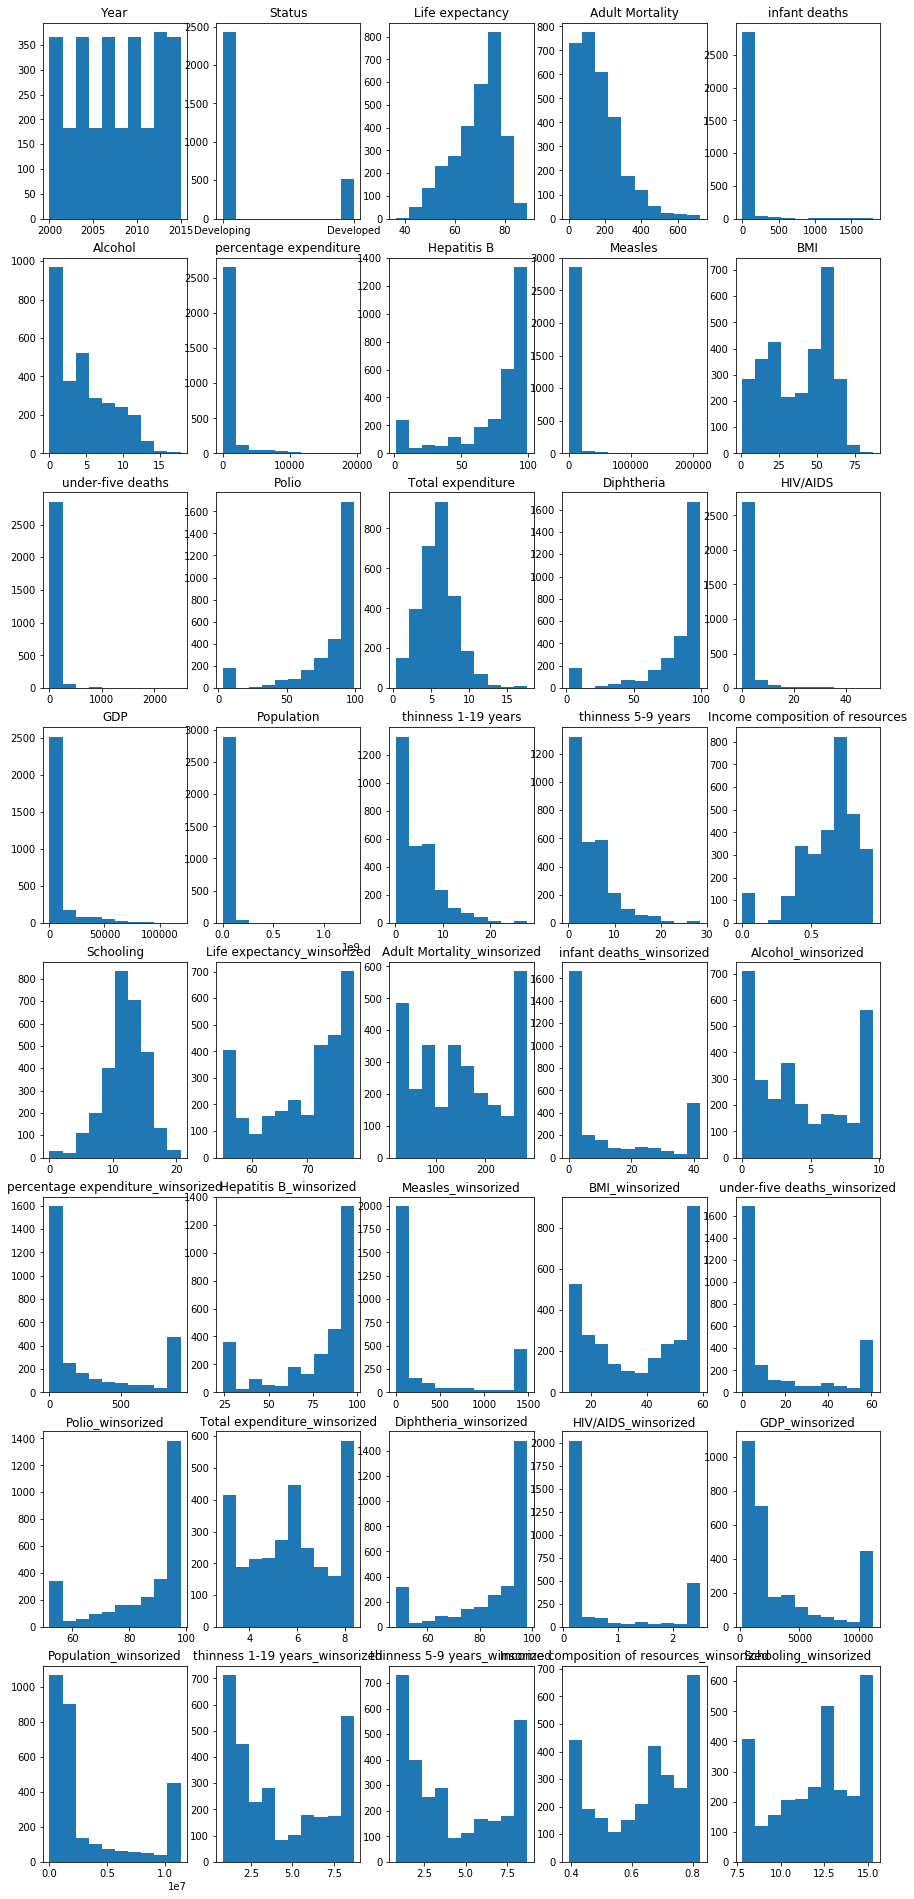

In [447]:
#histogram of final dataset

i = 1
plt.figure(figsize=(15,10))
for column_name in df.columns[1:]:
    plt.subplot(9,5,i)
    plt.hist(df[column_name])
    plt.title(df.columns[i])
    i = i+1   
    
plt.subplots_adjust(bottom=-2)
plt.tight_layout()
plt.show()

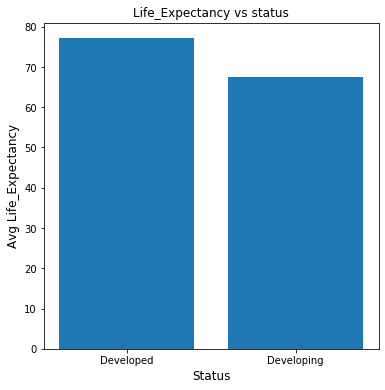

In [448]:
#univariate analysis with categoricals

plt.figure(figsize=(6,6))
plt.bar(df.groupby('Status')['Status'].count().index,df.groupby('Status')['Life expectancy_winsorized'].mean())
plt.xlabel("Status",fontsize=12)
plt.ylabel("Avg Life_Expectancy",fontsize=12)
plt.title("Life_Expectancy vs status")
plt.show()

Text(0, 0.5, 'Country')

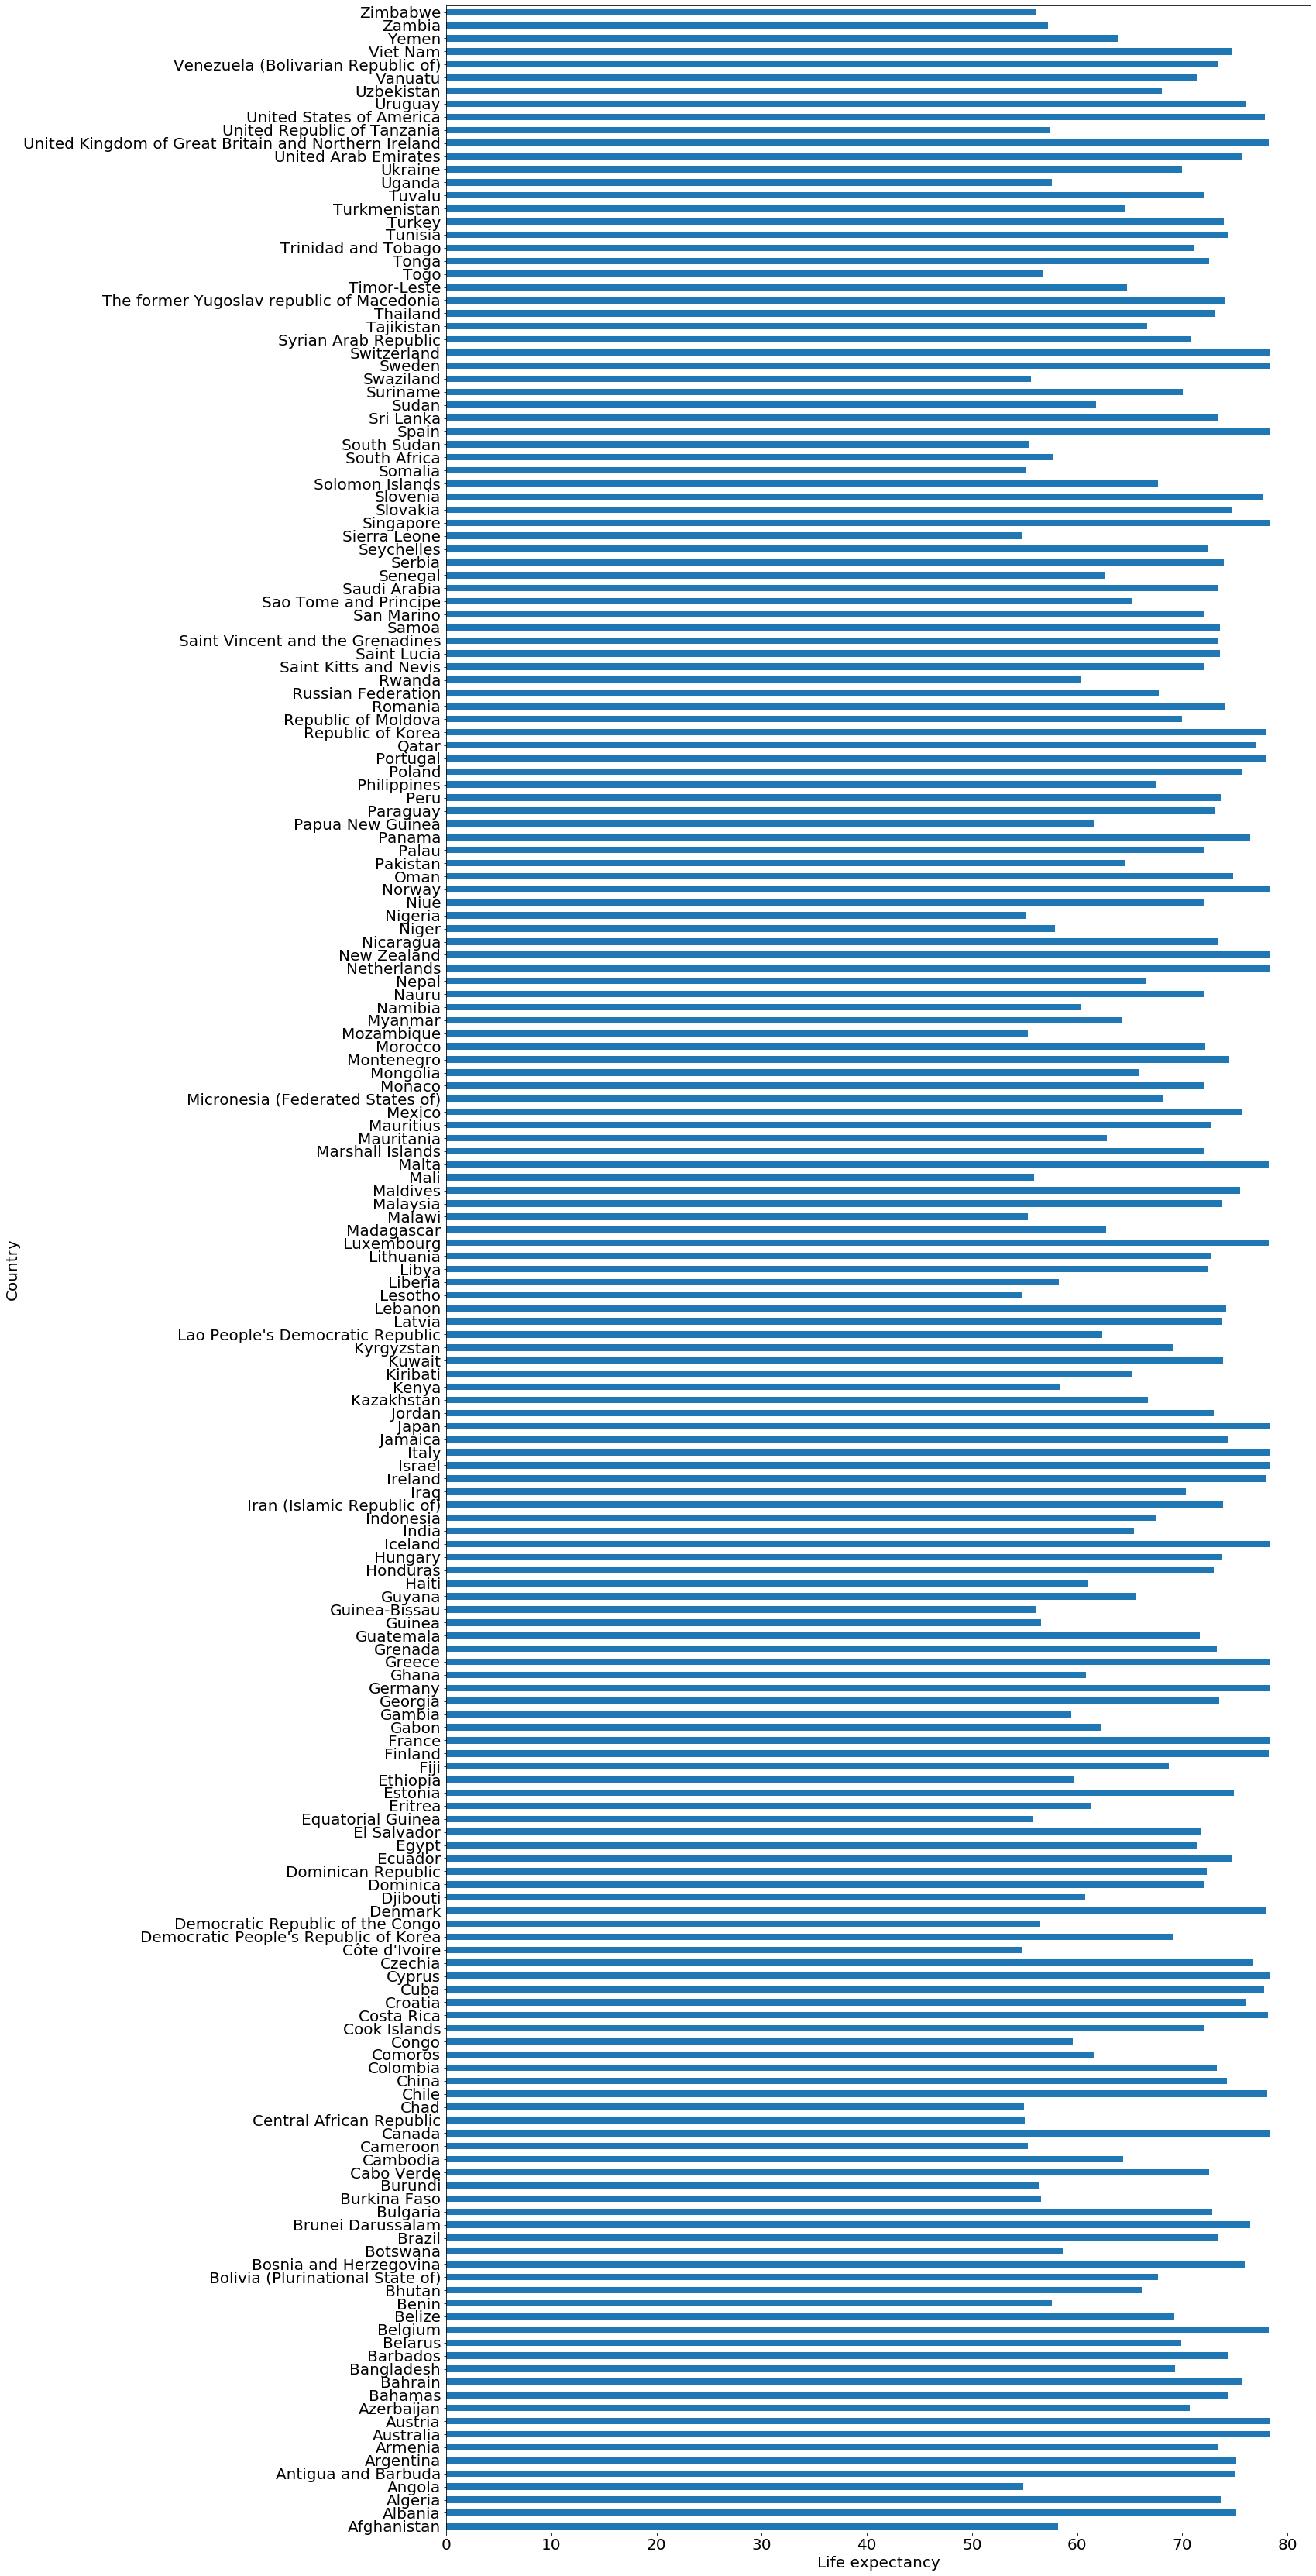

In [497]:
#plt.figure(figsize=(50,20))

#plt.barh(df.groupby('Country')['Country'].count().index, df.groupby('Country')['Life expectancy_winsorized'].mean())
df_country = df.groupby('Country')['Life expectancy_winsorized'].mean()
df_country.plot(kind='barh', figsize=(20,60), fontsize=20)
plt.xlabel('Life expectancy',size=20)
plt.ylabel('Country',size=20)


Text(0, 0.5, 'Life expectancy')

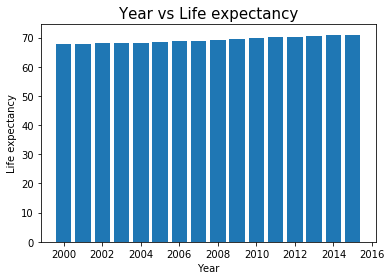

In [496]:
plt.bar(df.groupby('Year')['Year'].count().index, df.groupby('Year')['Life expectancy_winsorized'].mean())
plt.title('Year vs Life expectancy', size = 15)
plt.xlabel('Year', size=10)
plt.ylabel('Life expectancy',size=10)

In [508]:
#create the final data frame so we only focus on the wisorized columns
df_final = pd.concat([df.iloc[:,:3], df.iloc[:,22:]],axis=1)
df_final

,Country,Year,Status,Life expectancy_winsorized,Adult Mortality_winsorized,infant deaths_winsorized,Alcohol_winsorized,percentage expenditure_winsorized,Hepatitis B_winsorized,Measles_winsorized,...,Polio_winsorized,Total expenditure_winsorized,Diphtheria_winsorized,HIV/AIDS_winsorized,GDP_winsorized,Population_winsorized,thinness 1-19 years_winsorized,thinness 5-9 years_winsorized,Income composition of resources_winsorized,Schooling_winsorized
0,Afghanistan,2015,Developing,65.0,263.0,42,0.02,71.279624,65.0,1154,...,52.0,8.16,65.0,0.1,584.259210,11366189.0,8.7,8.7,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,42,0.02,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,8.7,8.7,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,42,0.02,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,11366189.0,8.7,8.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,42,0.02,78.184215,67.0,1483,...,67.0,8.38,67.0,0.1,669.959000,3696958.0,8.7,8.7,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,42,0.02,7.097109,68.0,1483,...,68.0,7.87,68.0,0.1,187.789910,2978599.0,8.7,8.7,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,54.8,284.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,2.5,454.366654,11366189.0,8.7,8.7,0.407,9.2
2934,Zimbabwe,2003,Developing,54.8,284.0,26,4.06,0.000000,24.0,998,...,52.0,6.52,68.0,2.5,453.351155,11366189.0,8.7,8.7,0.418,9.5
2935,Zimbabwe,2002,Developing,54.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,2.5,187.789910,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,54.8,284.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,2.5,548.587312,11366189.0,1.6,1.7,0.427,9.8


In [509]:
df_final.corr()

,Year,Life expectancy_winsorized,Adult Mortality_winsorized,infant deaths_winsorized,Alcohol_winsorized,percentage expenditure_winsorized,Hepatitis B_winsorized,Measles_winsorized,BMI_winsorized,under-five deaths_winsorized,Polio_winsorized,Total expenditure_winsorized,Diphtheria_winsorized,HIV/AIDS_winsorized,GDP_winsorized,Population_winsorized,thinness 1-19 years_winsorized,thinness 5-9 years_winsorized,Income composition of resources_winsorized,Schooling_winsorized
Year,1.000000,0.136618,-0.045968,-0.047784,-0.060522,0.034195,0.245293,-0.133978,0.097098,-0.052350,0.123430,0.064945,0.154536,-0.093121,0.131913,0.031502,-0.032222,-0.031192,0.182682,0.189776
Life expectancy_winsorized,0.136618,1.000000,-0.642859,-0.594828,0.388918,0.480543,0.374819,-0.340415,0.612621,-0.620603,0.587712,0.248043,0.582651,-0.804071,0.523214,-0.094136,-0.595252,-0.597159,0.810455,0.759729
Adult Mortality_winsorized,-0.045968,-0.642859,1.000000,0.363124,-0.221845,-0.342367,-0.202684,0.187387,-0.396328,0.376792,-0.337385,-0.170104,-0.332533,0.491849,-0.359315,0.072370,0.383894,0.397110,-0.524036,-0.472927
infant deaths_winsorized,-0.047784,-0.594828,0.363124,1.000000,-0.338981,-0.365693,-0.270111,0.572199,-0.475531,0.995683,-0.430365,-0.184842,-0.411131,0.425000,-0.382695,0.366726,0.428071,0.446864,-0.516615,-0.550547
Alcohol_winsorized,-0.060522,0.388918,-0.221845,-0.338981,1.000000,0.384026,0.122887,-0.185555,0.345182,-0.335576,0.262534,0.354657,0.259731,-0.149882,0.393687,-0.001433,-0.459938,-0.449650,0.480143,0.520668
percentage expenditure_winsorized,0.034195,0.480543,-0.342367,-0.365693,0.384026,1.000000,0.134650,-0.197865,0.357457,-0.366788,0.274040,0.202180,0.269461,-0.280586,0.838557,-0.013070,-0.351152,-0.356413,0.539652,0.528391
Hepatitis B_winsorized,0.245293,0.374819,-0.202684,-0.270111,0.122887,0.134650,1.000000,-0.247989,0.243169,-0.279620,0.593214,0.144176,0.650019,-0.327084,0.168935,-0.082189,-0.161790,-0.172444,0.343067,0.346786
Measles_winsorized,-0.133978,-0.340415,0.187387,0.572199,-0.185555,-0.197865,-0.247989,1.000000,-0.338180,0.570338,-0.311925,-0.182800,-0.300464,0.208060,-0.208039,0.241616,0.302490,0.312339,-0.275779,-0.326350
BMI_winsorized,0.097098,0.612621,-0.396328,-0.475531,0.345182,0.357457,0.243169,-0.338180,1.000000,-0.493857,0.366199,0.255873,0.358539,-0.489460,0.398870,-0.064622,-0.590007,-0.601101,0.603150,0.586790
under-five deaths_winsorized,-0.052350,-0.620603,0.376792,0.995683,-0.335576,-0.366788,-0.279620,0.570338,-0.493857,1.000000,-0.444652,-0.188496,-0.426454,0.454284,-0.385485,0.357254,0.434206,0.452835,-0.534818,-0.563510


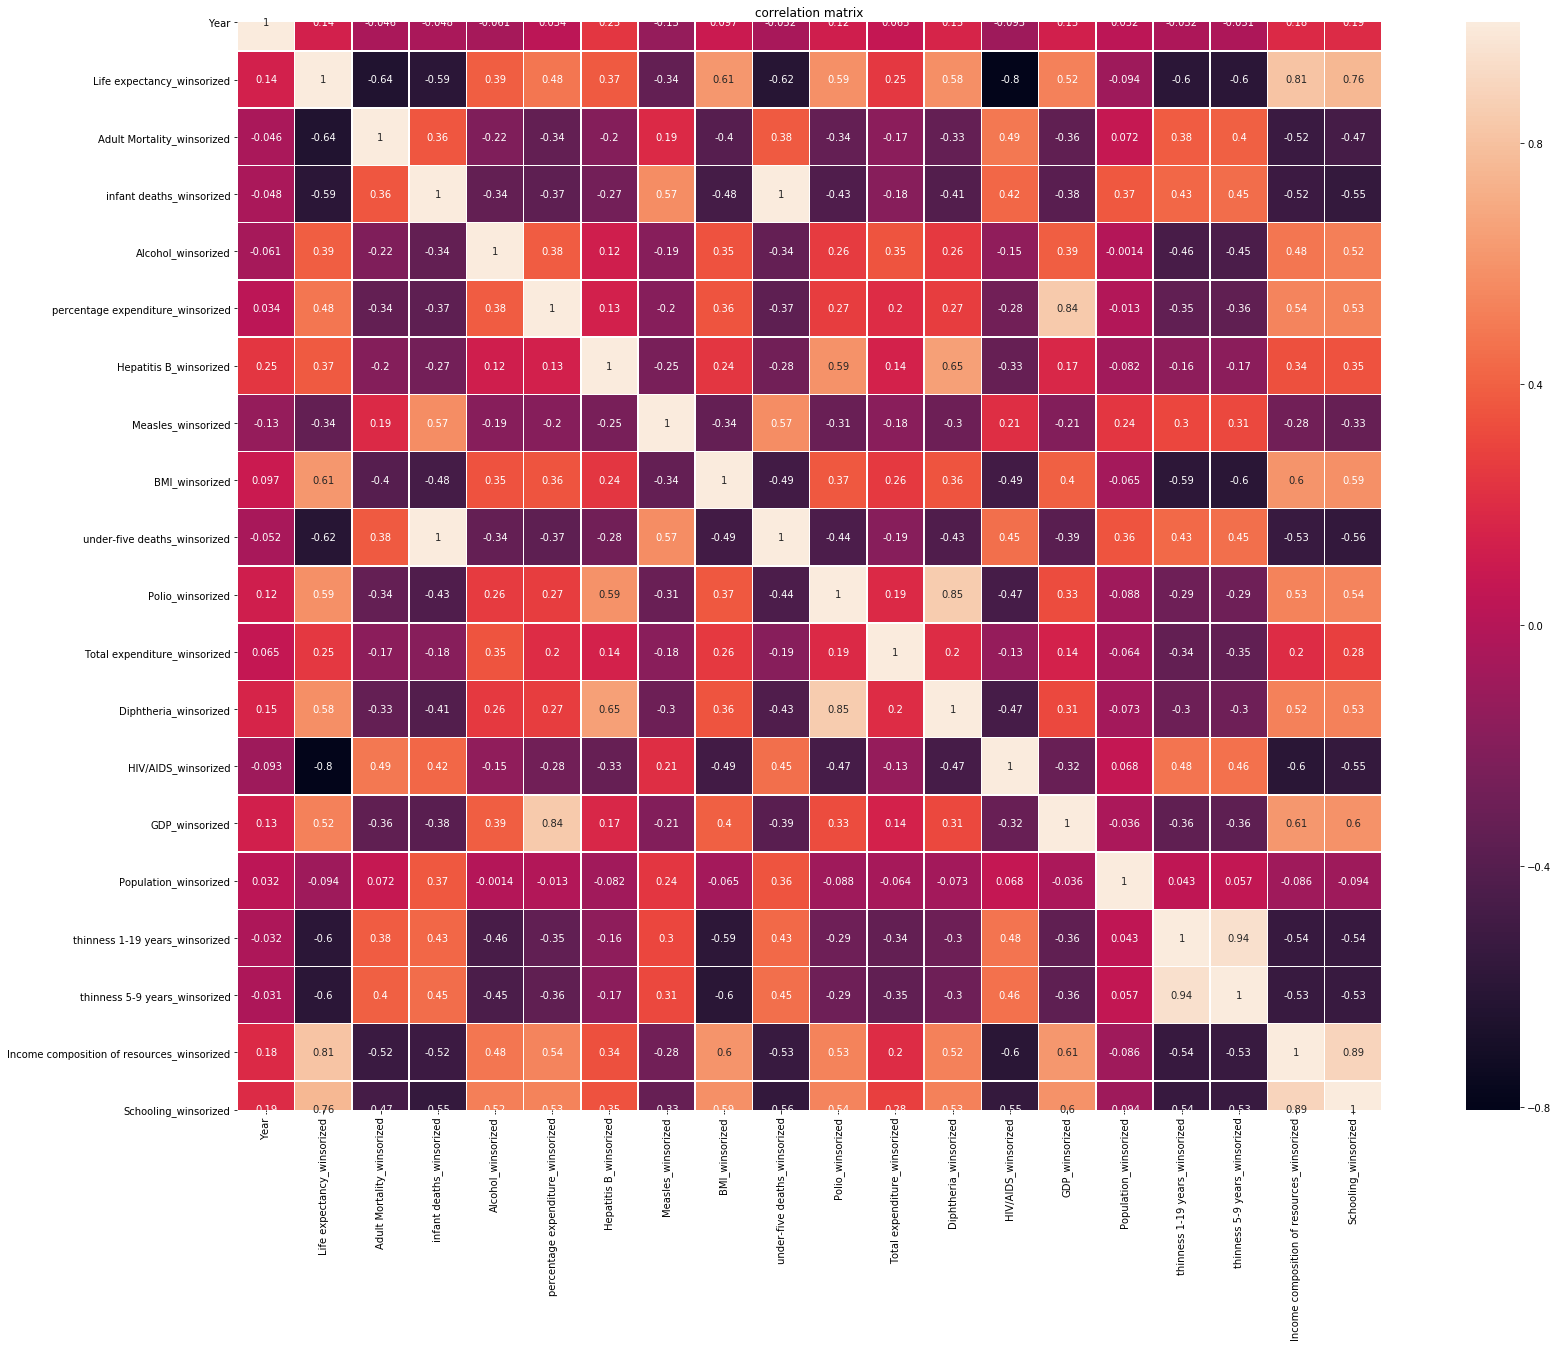

In [510]:
plt.figure(figsize=(30,20))

sns.heatmap(df_final.corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix")

plt.show()


From the heatmap we can see that we can use either thinness 1-19/thinness 5-9 years because they have a very high correlation value (0.94). income composition of resourced and schooling are also very highly correlated (0.89). Polio and Diptheria are also highly correlated(0.85). We will start out with a correlation cuttoff value of 0.6. With respect to life expectancy: income composition of resources, thinness 5-9, HIV/AIDS,under-five deaths, BMI, and adult mortality have correlation values of at least 0.6. So we will use those in our model.

In [514]:
#determine if there is a statistical difference in life expectencies in developed/developing countries
stats.ttest_ind(df_final.loc[df['Status']=='Developed','Life expectancy_winsorized'],
                df_final.loc[df['Status']=='Developing','Life expectancy_winsorized'])



Ttest_indResult(statistic=27.95681499264391, pvalue=1.0696512560301427e-152)

With a p-value less than 0.05 we can say that the life expectancy in developed and developing countries is statistically significant. Thus, we will include status in our features for the model.

In summary, after cleaning the data we have concluded that there will initially be seven features. The numerical features will be income composition of resources, thinness 5-9 years, HIV/AIDS, under-five deaths, BMI, and adult mortality. These features have correlation values off at least 0.6 The categorical feature we will be using is status because the life expectancies in developing and developed countries were statistically different. 